CIFAR-100은 32x32픽셀의 컬러이미지(RGB) 60000개로 이루어져 있으며

( training set - 50000, test set - 10000 )

각 이미지는 100개의 클래스로 구분되어있다.

### Import packages
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T

import pickle


/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Setup a device

In [2]:
# Device configuration

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('device:', device)

device: cuda


### Progress monitor
---

In [3]:
from IPython.display import HTML, display


# Custom IPython progress bar for training
class ProgressMonitor(object):

    tmpl = """
        <table style="width: 100%;">
            <tbody>
                <tr>
                    <td style="width: 30%;">
                     <b>Loss: {loss:0.4f}</b> &nbsp&nbsp&nbsp {value} / {length}
                    </td>
                    <td style="width: 70%;">
                        <progress value='{value}' max='{length}', style='width: 100%'>{value}</progress>
                    </td>
                </tr>
            </tbody>
        </table>
        """

    def __init__(self, length):
        self.length = length
        self.count = 0
        self.display = display(self.html(0, 0), display_id=True)

    def html(self, count, loss):
        return HTML(self.tmpl.format(length=self.length, value=count, loss=loss))

    def update(self, count, loss):
        self.count += count
        self.display.update(self.html(self.count, loss))

### Load the datasets
---

In [4]:

# transform_train = T.Compose( [T.ToTensor(), T.Normalize( (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) )] )
# transform_train = T.Compose( [T.RandomCrop(32, padding=4), T.ColorJitter(), T.RandomPerspective(), T.RandomHorizontalFlip(), T.ToTensor(), T.Normalize( (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) )] )
# transform_train = T.Compose( [T.RandomCrop(32, padding=4, padding_mode='reflect'), T.RandomHorizontalFlip(), T.ToTensor(), T.Normalize( (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) )] )
# transform_train = T.Compose( [T.RandomCrop(32, padding=4, padding_mode='reflect'), T.RandomHorizontalFlip(), T.RandomVerticalFlip(), T.RandomPerspective(distortion_scale=0.2, p=0.3), T.ToTensor(), T.Normalize( (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) )] )
transform_train = T.Compose( [T.RandomCrop(32, padding=4, padding_mode='reflect'), T.ColorJitter(), T.RandomHorizontalFlip(), T.RandomPerspective(distortion_scale=0.4, p=0.9), T.ToTensor(), T.Normalize( (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) )] )
transform_test = T.Compose( [T.ToTensor(), T.Normalize( (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) )] )

# pytorch augmentation 이용 -> transform_train만 수정 가능, transform_test 수정 불가.

train_set = torchvision.datasets.CIFAR100('./data', train=True, download=True, transform=transform_train )
test_set = torchvision.datasets.CIFAR100('./data', train=False, download=True, transform=transform_test )

classes = train_set.classes


Files already downloaded and verified
Files already downloaded and verified


In [5]:
print(train_set.data.shape)
print(test_set.data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


### Preview the data
---

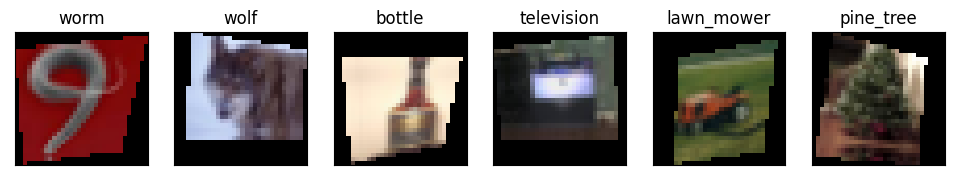

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)

temp_loader = torch.utils.data.DataLoader(train_set, batch_size=30, shuffle=True)

dataiter = iter(temp_loader)
images, labels = next( dataiter )

images = images[:6]
labels = labels[:6]

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

### Specify a model architecture
---


In [8]:
# CNN의 구조를 변경
# simpleCNN, GoogleNet, VGGNet, ResNet

class SimpleCNN(nn.Module):
    # -----
    class basic_block(nn.Module):
        def __init__(self, numOf_inCH, numOf_outCH, stride=1):
            super().__init__()

            self.residual_function = nn.Sequential(
                nn.Conv2d(numOf_inCH, numOf_outCH, kernel_size=3, stride=stride, padding=1, bias=False),
                nn.BatchNorm2d(numOf_outCH),
                nn.ReLU(inplace=True),
                nn.Conv2d(numOf_outCH, numOf_outCH, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(numOf_outCH)
            )

            self.shortcut = nn.Sequential()

            if stride != 1 or numOf_inCH != numOf_outCH:
                self.shortcut = nn.Sequential(
                    nn.Conv2d(numOf_inCH, numOf_outCH, kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(numOf_outCH)
                )

        def forward(self, x):
            return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

    # ----- basic_block end


    # -----
    def __init__(self, block=basic_block, num_block=[2, 3, 3, 2], num_classes=100):
        super().__init__()

        self.numOf_inCH = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
            )
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, numOf_outCH, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.numOf_inCH, numOf_outCH, stride))
            self.numOf_inCH = numOf_outCH

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output
# ----- SimpleCNN end


'\n    def __init__(self):\n        super().__init__()\n\n        self.conv_layers = nn.Sequential(\n\n            ######## 수정 가능\n\n            # Conv2d()에서 kernel_size=3, padding=1을 사용하면 이미지 크기가 유지됩니다.\n\n            #### 입력 이미지 크기 32x32\n\n            # 채널 3 -> 32\n            nn.Conv2d( in_channels=3, out_channels=32, kernel_size=3, padding=1 ),\n            nn.BatchNorm2d(32),\n            nn.ReLU(),\n\n            nn.Conv2d( in_channels=32, out_channels=32, kernel_size=3, padding=1 ),\n            nn.BatchNorm2d(32),\n            nn.ReLU(),\n\n            #### 이미지 크기 절반으로 -> 16x16\n            nn.MaxPool2d(2),\n\n            # 채널 32 -> 64\n            nn.Conv2d( in_channels=32, out_channels=64, kernel_size=3, padding=1 ),\n            nn.BatchNorm2d(64),\n            nn.ReLU(),\n\n            # 채널 64 -> 64\n            nn.Conv2d( in_channels=64, out_channels=64, kernel_size=3, padding=1 ),\n            nn.BatchNorm2d(64),\n            nn.ReLU(),\n\n            # 채널 64 -> 64\n    

In [9]:
# 모델 테스트
# 랜덤한 값으로 만든 이미지를 모델에 통과시켜 본 후 결과 텐서의 사이즈가 (7, 100)이 나오는지 확인된다면 OK.
# 이 코드가 에러가 나는 경우 Conv2d의 채널 수가 맞는지 fc layer의 노드 수가 맞는지 확인 필요

# 배치사이즈 7
# RGB 3채널
# 이미지 사이즈 32x32
# 랜덤값의 입력 데이터를 모델에 통과시켜 결과 모양을 확인

temp = SimpleCNN()
output = torch.randn( 7, 3, 32, 32)

print( temp(output).size() )


torch.Size([7, 100])


### Hyperparameters
---


In [10]:
# 하이퍼파라미터

batch_size = 16 # 배치 사이즈 (한번에 몇 개의 이미지를 배치로 학습할지)
learning_rate = 0.0002 # 학습률 (학습 진행 스텝의 크기)
num_epochs = 100 # 에폭 수 (데이터셋 한번 학습 단위, 얼마나 학습을 반복할 것인지)

extra_epochs = 5
extra_timing_ratio = 0.91
# extra_learning_rate = 0.0004

### Setup the data loaders
---


In [11]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)



### Instantiate the model
---

In [12]:
model = SimpleCNN()

model.to(device)


SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2_x): Sequential(
    (0): basic_block(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): basic_block(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

### Train the model
---


In [13]:
import math
import torch
from torch.optim.lr_scheduler import _LRScheduler

# optimizer 방식을 변경 원하는 경우 변경 가능

criterion = nn.CrossEntropyLoss()

# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.0001)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.5e-4)

# Tip: optimizer 수정.
# 1. optimizer 선택, 추천 : SGD, Adam -> pytorch optimizer 검색
# 2. learning rate 설정: SGD에서 0.1 -> Adam에서 0.001 (1/50 ~ 1/100)
# 3. weight decay : 과적합 방지 (추가) 0.0001 ~ 0.0005 정도
# 4. learning rate scheduler : 학습 중간에 lr를 바꿔주는 방법. lr_scheduler pytorch 검색 ->
# scheduler = CosineAnnealingWarmupRestarts(optimizer, first_cycle_steps=30, cycle_mult=1.0, max_lr=0.004, min_lr=0.00001, warmup_steps=5, gamma=0.5)
# scheduler = CosineAnnealingWarmupRestarts(optimizer, first_cycle_steps=25, cycle_mult=1.0, max_lr=0.001, min_lr=0.0000001, warmup_steps=5, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 60, 80], gamma=0.2)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 25, 45, 70], gamma=0.1)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=4, verbose=True)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs=num_epochs, steps_per_epoch=len(train_loader))

In [14]:
from statistics import mean

def train(optimizer, model, num_epochs=10, first_epoch=1):

    extra_flag = False

    criterion = nn.CrossEntropyLoss()

    train_losses = []
    test_losses = []

    # Best test accuracy
    best_test_acc = 0

    for epoch in range(first_epoch, first_epoch + num_epochs + extra_epochs):
        print('Epoch', epoch)

        # train phase
        model.train()

        # create a progress bar
        progress = ProgressMonitor(length=len(train_set))

        # keep track of predictions
        correct_train = 0

        batch_losses = []

        for batch, targets in train_loader:

            # Move the training data to the GPU
            batch = batch.to(device)
            targets = targets.to(device)

            # clear previous gradient computation
#             optimizer.zero_grad()

            # forward propagation
            outputs = model(batch)

            # calculate the loss
            loss = criterion(outputs, targets)

            # backpropagate to compute gradients
            loss.backward()

            #!
            grad_clip = 0.1
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            # update model weights
            optimizer.step()
            optimizer.zero_grad() #!

            batch_losses.append(loss.item())

            # accumulate correct count
            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == targets.data)

            # update progress bar
            progress.update(batch.shape[0], mean(batch_losses) )

            # --------------------
            if not extra_flag:
                scheduler.step()
            # --------------------

        # --------------------
        if int(num_epochs * extra_timing_ratio) == epoch:
            extra_flag = True
        elif int(num_epochs * extra_timing_ratio) + extra_epochs == epoch:
            extra_flag = False
        # --------------------
        train_losses.append( mean(batch_losses))


        # test phase
        model.eval()

        y_pred = []

        correct_test = 0

        # We don't need gradients for test, so wrap in
        # no_grad to save memory
        with torch.no_grad():

            for batch, targets in test_loader:

                # Move the training batch to the GPU
                batch = batch.to(device)
                targets = targets.to(device)

                # forward propagation
                outputs = model(batch)

                # calculate the loss
                loss = criterion(outputs, targets)

                # save predictions
                y_pred.extend( outputs.argmax(dim=1).cpu().numpy() )

                # accumulate correct count
                _, preds = torch.max(outputs, 1)
                correct_test += torch.sum(preds == targets.data)



        # Calculate accuracy
        train_acc = correct_train.item() / train_set.data.shape[0]
        test_acc = correct_test.item() / test_set.data.shape[0]

        print('Training accuracy: {:.2f}%'.format(float(train_acc) * 100), "lr: {:.8f}\t".format(optimizer.param_groups[0]["lr"]))
        print('Test accuracy: {:.2f}%'.format(float(test_acc) * 100))

        # --------------------
#         scheduler.step()
        # --------------------

        # Save the best model
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            if SAVEATDRIVE:
                torch.save( model.state_dict(), '/content/drive/MyDrive/인공지능의이해와활용/best_model_v'+str(VERSION)+'.pt' )
            else:
                torch.save( model.state_dict(), 'best_model_v'+str(VERSION)+'.pt' )
            print( '    ==> Best model saved!\n' )


    return train_losses, test_losses, y_pred

### Checkpointing
---

In [15]:
#@title
train_losses, test_losses, y_pred = train(optimizer, model, num_epochs=num_epochs)

Epoch 1


Loss: 4.0819 50000 / 50000,50000


Training accuracy: 8.20% lr: 0.00000853	
Test accuracy: 14.72%
    ==> Best model saved!

Epoch 2


Loss: 3.6556 47216 / 50000,47216


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Training accuracy: 18.96% lr: 0.00001270	
Test accuracy: 25.07%
    ==> Best model saved!

Epoch 4


Loss: 3.1932 50000 / 50000,50000


Training accuracy: 22.66% lr: 0.00001630	
Test accuracy: 29.16%
    ==> Best model saved!

Epoch 5


Loss: 3.0269 50000 / 50000,50000


Training accuracy: 25.64% lr: 0.00002086	
Test accuracy: 32.52%
    ==> Best model saved!

Epoch 6


Loss: 2.8625 50000 / 50000,50000


Training accuracy: 28.90% lr: 0.00002633	
Test accuracy: 34.18%
    ==> Best model saved!

Epoch 7


Loss: 2.7087 50000 / 50000,50000


Training accuracy: 32.12% lr: 0.00003266	
Test accuracy: 36.33%
    ==> Best model saved!

Epoch 8


Loss: 2.5721 50000 / 50000,50000


Training accuracy: 34.85% lr: 0.00003976	
Test accuracy: 39.17%
    ==> Best model saved!

Epoch 9


Loss: 2.4479 50000 / 50000,50000


Training accuracy: 37.25% lr: 0.00004757	
Test accuracy: 40.87%
    ==> Best model saved!

Epoch 10


Loss: 2.3196 50000 / 50000,50000


Training accuracy: 40.15% lr: 0.00005600	
Test accuracy: 43.62%
    ==> Best model saved!

Epoch 11


Loss: 2.2009 50000 / 50000,50000


Training accuracy: 42.65% lr: 0.00006495	
Test accuracy: 47.38%
    ==> Best model saved!

Epoch 12


Loss: 2.1048 50000 / 50000,50000


Training accuracy: 44.65% lr: 0.00007434	
Test accuracy: 49.01%
    ==> Best model saved!

Epoch 13


Loss: 2.0090 50000 / 50000,50000


Training accuracy: 46.77% lr: 0.00008404	
Test accuracy: 49.91%
    ==> Best model saved!

Epoch 14


Loss: 1.9086 50000 / 50000,50000


Training accuracy: 48.86% lr: 0.00009397	
Test accuracy: 51.99%
    ==> Best model saved!

Epoch 15


Loss: 1.8420 50000 / 50000,50000


Training accuracy: 50.19% lr: 0.00010400	
Test accuracy: 54.71%
    ==> Best model saved!

Epoch 16


Loss: 1.7785 50000 / 50000,50000


Training accuracy: 51.91% lr: 0.00011404	
Test accuracy: 53.45%
Epoch 17


Loss: 1.7107 50000 / 50000,50000


Training accuracy: 53.25% lr: 0.00012396	
Test accuracy: 55.82%
    ==> Best model saved!

Epoch 18


Loss: 1.6463 50000 / 50000,50000


Training accuracy: 54.86% lr: 0.00013367	
Test accuracy: 57.63%
    ==> Best model saved!

Epoch 19


Loss: 1.5949 50000 / 50000,50000


Training accuracy: 55.95% lr: 0.00014305	
Test accuracy: 58.25%
    ==> Best model saved!

Epoch 20


Loss: 1.5405 50000 / 50000,50000


Training accuracy: 57.51% lr: 0.00015200	
Test accuracy: 58.76%
    ==> Best model saved!

Epoch 21


Loss: 1.4941 50000 / 50000,50000


Training accuracy: 58.43% lr: 0.00016043	
Test accuracy: 60.19%
    ==> Best model saved!

Epoch 22


Loss: 1.4607 50000 / 50000,50000


Training accuracy: 59.19% lr: 0.00016824	
Test accuracy: 58.51%
Epoch 23


Loss: 1.3975 50000 / 50000,50000


Training accuracy: 60.83% lr: 0.00017534	
Test accuracy: 58.65%
Epoch 24


Loss: 1.3711 50000 / 50000,50000


Training accuracy: 61.51% lr: 0.00018167	
Test accuracy: 61.17%
    ==> Best model saved!

Epoch 25


Loss: 1.3159 50000 / 50000,50000


Training accuracy: 62.85% lr: 0.00018714	
Test accuracy: 61.80%
    ==> Best model saved!

Epoch 26


Loss: 1.2844 50000 / 50000,50000


Training accuracy: 63.61% lr: 0.00019170	
Test accuracy: 63.41%
    ==> Best model saved!

Epoch 27


Loss: 1.2540 50000 / 50000,50000


Training accuracy: 64.25% lr: 0.00019530	
Test accuracy: 62.64%
Epoch 28


Loss: 1.2016 50000 / 50000,50000


Training accuracy: 65.44% lr: 0.00019790	
Test accuracy: 63.44%
    ==> Best model saved!

Epoch 29


Loss: 1.1641 50000 / 50000,50000


Training accuracy: 66.78% lr: 0.00019947	
Test accuracy: 65.87%
    ==> Best model saved!

Epoch 30


Loss: 1.1310 50000 / 50000,50000


Training accuracy: 67.28% lr: 0.00020000	
Test accuracy: 64.77%
Epoch 31


Loss: 1.0891 50000 / 50000,50000


Training accuracy: 68.31% lr: 0.00019990	
Test accuracy: 66.16%
    ==> Best model saved!

Epoch 32


Loss: 1.0545 50000 / 50000,50000


Training accuracy: 69.35% lr: 0.00019960	
Test accuracy: 65.73%
Epoch 33


Loss: 1.0263 50000 / 50000,50000


Training accuracy: 69.97% lr: 0.00019909	
Test accuracy: 65.62%
Epoch 34


Loss: 0.9775 50000 / 50000,50000


Training accuracy: 71.15% lr: 0.00019839	
Test accuracy: 67.02%
    ==> Best model saved!

Epoch 35


Loss: 0.9537 50000 / 50000,50000


Training accuracy: 72.09% lr: 0.00019749	
Test accuracy: 66.69%
Epoch 36


Loss: 0.9196 50000 / 50000,50000


Training accuracy: 72.68% lr: 0.00019640	
Test accuracy: 67.78%
    ==> Best model saved!

Epoch 37


Loss: 0.8889 50000 / 50000,50000


Training accuracy: 73.54% lr: 0.00019511	
Test accuracy: 68.02%
    ==> Best model saved!

Epoch 38


Loss: 0.8614 50000 / 50000,50000


Training accuracy: 74.38% lr: 0.00019362	
Test accuracy: 68.04%
    ==> Best model saved!

Epoch 39


Loss: 0.8246 50000 / 50000,50000


Training accuracy: 75.43% lr: 0.00019195	
Test accuracy: 69.56%
    ==> Best model saved!

Epoch 40


Loss: 0.8033 50000 / 50000,50000


Training accuracy: 75.92% lr: 0.00019010	
Test accuracy: 68.71%
Epoch 41


Loss: 0.7789 50000 / 50000,50000


Training accuracy: 76.50% lr: 0.00018806	
Test accuracy: 68.21%
Epoch 42


Loss: 0.7503 50000 / 50000,50000


Training accuracy: 77.21% lr: 0.00018584	
Test accuracy: 69.85%
    ==> Best model saved!

Epoch 43


Loss: 0.7229 50000 / 50000,50000


Training accuracy: 78.25% lr: 0.00018346	
Test accuracy: 69.19%
Epoch 44


Loss: 0.6971 50000 / 50000,50000


Training accuracy: 78.73% lr: 0.00018090	
Test accuracy: 69.12%
Epoch 45


Loss: 0.6795 50000 / 50000,50000


Training accuracy: 79.26% lr: 0.00017818	
Test accuracy: 70.01%
    ==> Best model saved!

Epoch 46


Loss: 0.6446 50000 / 50000,50000


Training accuracy: 80.07% lr: 0.00017531	
Test accuracy: 71.52%
    ==> Best model saved!

Epoch 47


Loss: 0.6214 50000 / 50000,50000


Training accuracy: 80.91% lr: 0.00017228	
Test accuracy: 71.14%
Epoch 48


Loss: 0.6092 50000 / 50000,50000


Training accuracy: 81.19% lr: 0.00016911	
Test accuracy: 71.03%
Epoch 49


Loss: 0.5764 50000 / 50000,50000


Training accuracy: 82.29% lr: 0.00016579	
Test accuracy: 71.10%
Epoch 50


Loss: 0.5632 50000 / 50000,50000


Training accuracy: 82.41% lr: 0.00016235	
Test accuracy: 71.04%
Epoch 51


Loss: 0.5280 50000 / 50000,50000


Training accuracy: 83.39% lr: 0.00015878	
Test accuracy: 70.63%
Epoch 52


Loss: 0.5093 50000 / 50000,50000


Training accuracy: 84.04% lr: 0.00015509	
Test accuracy: 70.82%
Epoch 53


Loss: 0.4925 50000 / 50000,50000


Training accuracy: 84.55% lr: 0.00015129	
Test accuracy: 71.11%
Epoch 54


Loss: 0.4686 50000 / 50000,50000


Training accuracy: 85.24% lr: 0.00014739	
Test accuracy: 71.22%
Epoch 55


Loss: 0.4538 50000 / 50000,50000


Training accuracy: 85.66% lr: 0.00014339	
Test accuracy: 71.23%
Epoch 56


Loss: 0.4312 50000 / 50000,50000


Training accuracy: 86.23% lr: 0.00013930	
Test accuracy: 71.22%
Epoch 57


Loss: 0.4085 50000 / 50000,50000


Training accuracy: 87.14% lr: 0.00013514	
Test accuracy: 71.48%
Epoch 58


Loss: 0.3864 46272 / 50000,46272


Training accuracy: 88.23% lr: 0.00012660	
Test accuracy: 71.54%
Epoch 60


Loss: 0.3503 50000 / 50000,50000


Training accuracy: 88.64% lr: 0.00012225	
Test accuracy: 72.00%
    ==> Best model saved!

Epoch 61


Loss: 0.3384 50000 / 50000,50000


Training accuracy: 89.20% lr: 0.00011785	
Test accuracy: 72.26%
    ==> Best model saved!

Epoch 62


Loss: 0.3263 50000 / 50000,50000


Training accuracy: 89.64% lr: 0.00011342	
Test accuracy: 72.02%
Epoch 63


Loss: 0.3098 50000 / 50000,50000


Training accuracy: 90.00% lr: 0.00010896	
Test accuracy: 71.83%
Epoch 64


Loss: 0.2906 50000 / 50000,50000


Training accuracy: 90.76% lr: 0.00010449	
Test accuracy: 72.66%
    ==> Best model saved!

Epoch 65


Loss: 0.2717 50000 / 50000,50000


Training accuracy: 91.36% lr: 0.00010000	
Test accuracy: 72.88%
    ==> Best model saved!

Epoch 66


Loss: 0.2642 50000 / 50000,50000


Training accuracy: 91.57% lr: 0.00009551	
Test accuracy: 72.80%
Epoch 67


Loss: 0.2406 50000 / 50000,50000


Training accuracy: 92.32% lr: 0.00009104	
Test accuracy: 73.01%
    ==> Best model saved!

Epoch 68


Loss: 0.2243 50000 / 50000,50000


Training accuracy: 92.80% lr: 0.00008658	
Test accuracy: 72.77%
Epoch 69


Loss: 0.2160 50000 / 50000,50000


Training accuracy: 93.08% lr: 0.00008214	
Test accuracy: 73.03%
    ==> Best model saved!

Epoch 70


Loss: 0.2040 50000 / 50000,50000


Training accuracy: 93.49% lr: 0.00007775	
Test accuracy: 73.29%
    ==> Best model saved!

Epoch 71


Loss: 0.1870 50000 / 50000,50000


Training accuracy: 94.05% lr: 0.00007340	
Test accuracy: 74.08%
    ==> Best model saved!

Epoch 72


Loss: 0.1767 50000 / 50000,50000


Training accuracy: 94.37% lr: 0.00006910	
Test accuracy: 73.38%
Epoch 73


Loss: 0.1649 50000 / 50000,50000


Training accuracy: 94.78% lr: 0.00006486	
Test accuracy: 73.80%
Epoch 74


Loss: 0.1566 50000 / 50000,50000


Training accuracy: 95.01% lr: 0.00006070	
Test accuracy: 73.80%
Epoch 75


Loss: 0.1450 50000 / 50000,50000


Training accuracy: 95.48% lr: 0.00005661	
Test accuracy: 73.16%
Epoch 76


Loss: 0.1359 50000 / 50000,50000


Training accuracy: 95.78% lr: 0.00005261	
Test accuracy: 73.92%
Epoch 77


Loss: 0.1262 50000 / 50000,50000


Training accuracy: 96.05% lr: 0.00004871	
Test accuracy: 73.43%
Epoch 78


Loss: 0.1181 50000 / 50000,50000


Training accuracy: 96.32% lr: 0.00004491	
Test accuracy: 74.02%
Epoch 79


Loss: 0.1073 50000 / 50000,50000


Training accuracy: 96.67% lr: 0.00004122	
Test accuracy: 74.32%
    ==> Best model saved!

Epoch 80


Loss: 0.1019 50000 / 50000,50000


Training accuracy: 96.78% lr: 0.00003765	
Test accuracy: 74.46%
    ==> Best model saved!

Epoch 81


Loss: 0.0971 50000 / 50000,50000


Training accuracy: 96.99% lr: 0.00003421	
Test accuracy: 74.74%
    ==> Best model saved!

Epoch 82


Loss: 0.0808 24112 / 50000,24112


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Training accuracy: 97.51% lr: 0.00002772	
Test accuracy: 74.82%
    ==> Best model saved!

Epoch 84


Loss: 0.0787 50000 / 50000,50000


Training accuracy: 97.57% lr: 0.00002469	
Test accuracy: 74.80%
Epoch 85


Loss: 0.0680 50000 / 50000,50000


Training accuracy: 97.91% lr: 0.00002182	
Test accuracy: 74.41%
Epoch 86


Loss: 0.0648 50000 / 50000,50000


Training accuracy: 98.06% lr: 0.00001910	
Test accuracy: 75.02%
    ==> Best model saved!

Epoch 87


Loss: 0.0615 50000 / 50000,50000


Training accuracy: 98.21% lr: 0.00001654	
Test accuracy: 74.88%
Epoch 88


Loss: 0.0587 50000 / 50000,50000


Training accuracy: 98.28% lr: 0.00001416	
Test accuracy: 75.18%
    ==> Best model saved!

Epoch 89


Loss: 0.0530 50000 / 50000,50000


Training accuracy: 98.44% lr: 0.00001194	
Test accuracy: 75.75%
    ==> Best model saved!

Epoch 90


Loss: 0.0493 50000 / 50000,50000


Training accuracy: 98.61% lr: 0.00000990	
Test accuracy: 75.51%
Epoch 91


Loss: 0.0485 50000 / 50000,50000


Training accuracy: 98.56% lr: 0.00000805	
Test accuracy: 75.68%
Epoch 92


Loss: 0.0440 50000 / 50000,50000


Training accuracy: 98.77% lr: 0.00000805	
Test accuracy: 75.58%
Epoch 93


Loss: 0.0448 50000 / 50000,50000


Training accuracy: 98.73% lr: 0.00000805	
Test accuracy: 75.56%
Epoch 94


Loss: 0.0440 50000 / 50000,50000


Training accuracy: 98.75% lr: 0.00000805	
Test accuracy: 75.61%
Epoch 95


Loss: 0.0419 50000 / 50000,50000


Training accuracy: 98.77% lr: 0.00000805	
Test accuracy: 75.77%
    ==> Best model saved!

Epoch 96


Loss: 0.0420 50000 / 50000,50000


Training accuracy: 98.80% lr: 0.00000805	
Test accuracy: 75.65%
Epoch 97


Loss: 0.0437 50000 / 50000,50000


Training accuracy: 98.72% lr: 0.00000638	
Test accuracy: 75.57%
Epoch 98


Loss: 0.0385 50000 / 50000,50000


Training accuracy: 98.94% lr: 0.00000489	
Test accuracy: 75.87%
    ==> Best model saved!

Epoch 99


Loss: 0.0372 50000 / 50000,50000


Training accuracy: 98.96% lr: 0.00000360	
Test accuracy: 75.76%
Epoch 100


Loss: 0.0348 50000 / 50000,50000


Training accuracy: 99.02% lr: 0.00000251	
Test accuracy: 75.98%
    ==> Best model saved!

Epoch 101


Loss: 0.0350 50000 / 50000,50000


Training accuracy: 99.06% lr: 0.00000161	
Test accuracy: 75.87%
Epoch 102


Loss: 0.0358 50000 / 50000,50000


Training accuracy: 99.00% lr: 0.00000091	
Test accuracy: 75.91%
Epoch 103


Loss: 0.0357 50000 / 50000,50000


Training accuracy: 98.99% lr: 0.00000040	
Test accuracy: 76.02%
    ==> Best model saved!

Epoch 104


Loss: 0.0338 50000 / 50000,50000


Training accuracy: 99.08% lr: 0.00000010	
Test accuracy: 75.91%
Epoch 105


Loss: 0.0350 50000 / 50000,50000


Training accuracy: 99.05% lr: 0.00000000	
Test accuracy: 75.85%


### Make a CSV for submission
---

In [16]:
# Load the best model

model = SimpleCNN()
if SAVEATDRIVE:
    model.load_state_dict( torch.load('/content/drive/MyDrive/인공지능의이해와활용/best_model_v'+str(VERSION)+'.pt') )
else:
    model.load_state_dict( torch.load('best_model_v'+str(VERSION)+'.pt') )
model.to(device)


SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2_x): Sequential(
    (0): basic_block(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): basic_block(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [17]:

# test phase
model.eval()

# keep track of predictions
y_pred = []

# We don't need gradients for test, so wrap in
# no_grad to save memory
with torch.no_grad():

    for batch, targets in test_loader:

        # Move the training batch to the GPU
        batch = batch.to(device)
        targets = targets.to(device)

        # forward propagation
        predictions = model(batch)

        # save predictions
        y_pred.extend( predictions.argmax(dim=1).cpu().numpy() )



In [18]:
import csv

def make_pred_csv(model):
    if SAVEATDRIVE:
        with open('/content/drive/MyDrive/인공지능의이해와활용/cifar100_submit_v'+str(VERSION)+'.csv', mode='w') as pred_file:
            pred_writer = csv.writer(pred_file, delimiter=',')
            pred_writer.writerow(['id', 'Category'])

            for i, label in enumerate(y_pred):
                pred_writer.writerow([i+1, classes[label]])
    else:
        with open('cifar100_submit_v'+str(VERSION)+'.csv', mode='w') as pred_file:
            pred_writer = csv.writer(pred_file, delimiter=',')
            pred_writer.writerow(['id', 'Category'])

            for i, label in enumerate(y_pred):
                pred_writer.writerow([i+1, classes[label]])


make_pred_csv(model)